## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

Basically, we only need the context and stream

In [2]:
import pycuda.autoprimaryctx

In [3]:
import pycuda.driver as cuda
gpu_stream = cuda.Stream()

# Sampling GRF: FFT Approach

Use GPU for sampling random numbers (first step of immense speed-up)

In [4]:
nx = 10#630
ny = 5#315

In [5]:
from gpuocean.utils import Common

u_gpu = Common.CUDAArray2D(gpu_stream, nx, ny, 0, 0, np.zeros((ny,nx), dtype=np.float32))

In [6]:
from pycuda.curandom import XORWOWRandomNumberGenerator
rng = XORWOWRandomNumberGenerator()

In [7]:
rng.fill_normal(u_gpu.data, stream=gpu_stream)

In [8]:
u = u_gpu.download(gpu_stream)

In [9]:
u.shape

(5, 10)

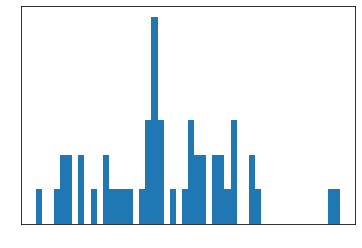

In [10]:
_ = plt.hist(u.flatten(), bins=50)

Only one row of distance matrix needed

In [11]:
dist = np.zeros((nx*ny))
for j in range(ny):
    for i in range(nx):
        dist[j*nx+i] = np.sqrt(i**2+j**2)
        dist[j*nx+i] = min([np.sqrt(i**2+j**2),np.sqrt((i-nx)**2+j**2),np.sqrt(i**2+(j-ny)**2),np.sqrt((i-nx)**2+(j-ny)**2)]) # only periodic!! Otherwise complex fft values!!

In [12]:
phi = 0.1
corr = np.exp(-phi*dist**2)

In [13]:
cov_toepitz = np.reshape(corr, (ny, nx))

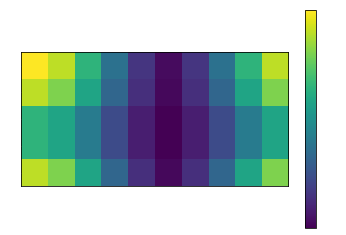

In [14]:
plt.imshow(cov_toepitz)
plt.colorbar()

## FFT on the CPU

In [15]:
# ctf = np.fft.fft2(cov_toepitz)
# ctfsm = np.sqrt(np.maximum(0,ctf))
# uf = np.fft.fft2(u)
# grf = np.fft.ifft2(ctfsm*uf).real

In [16]:
ctf = np.fft.rfft2(cov_toepitz)
ctfsm = np.sqrt(np.maximum(0,ctf))
uf = np.fft.rfft2(u)
grf = np.fft.irfft2(ctfsm*uf).real

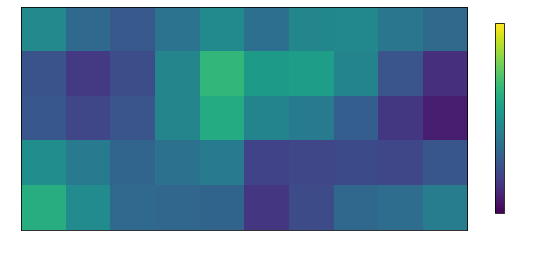

In [17]:
plt.figure(figsize=(10,5))
plt.imshow(grf, vmin=-2, vmax=2)
plt.colorbar(shrink=0.7)

##### Alternative code as in advectionDiffusion (same result upside down)

In [18]:
cmf = np.real(np.fft.fft2(cov_toepitz))
uif = np.fft.ifft2(u)
xf = np.real(np.fft.fft2(np.sqrt(np.maximum(cmf,0))*uif))

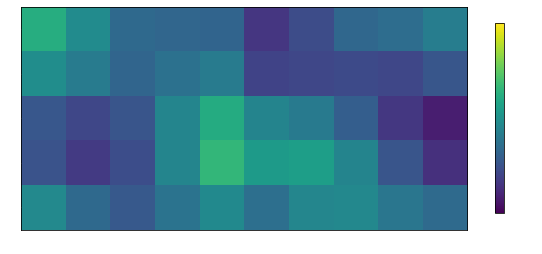

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(xf, origin="lower", vmin=-2, vmax=2)
plt.colorbar(shrink=0.7)

## FFT via skcuda (2D!)

In [20]:
import numpy as np

import pycuda.driver as cuda
from pycuda.tools import make_default_context
import pycuda.gpuarray as gpuarray

In [21]:
from gpuocean.utils import IPythonMagic

In [22]:
%cuda_context_handler gpu_ctx

In [23]:
from skcuda.fft import fft, ifft, Plan

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


##### Start with sanity checks

In [24]:
# https://forums.developer.nvidia.com/t/how-to-apply-scikit-cuda-2d-fft-pycuda/33055

data = np.random.randn(4,4)
print(data)

data_gpu = gpuarray.to_gpu(data.astype(np.float32))
out_gpu = gpuarray.empty(data.shape, np.complex64)

plan = Plan(data.shape, np.complex64, np.complex64)
fft(data_gpu, out_gpu, plan)
ifft(out_gpu, data_gpu, plan)

data_gpu.get()/np.product(data.shape)

[[-0.52710431 -1.11471687  0.49376394  0.8460334 ]
 [ 1.27400574 -0.32932747 -0.47151107  0.3941378 ]
 [ 0.5421381   0.70243583  0.41856754  0.08802374]
 [-0.03068851  0.59133888  0.34739635 -2.00417128]]


array([[-0.5271043 , -1.1147169 ,  0.49376398,  0.84603333],
       [ 1.2740057 , -0.32932743, -0.47151113,  0.39413786],
       [ 0.54213816,  0.70243585,  0.41856754,  0.08802384],
       [-0.03068852,  0.5913389 ,  0.3473963 , -2.0041714 ]],
      dtype=float32)

In [25]:
# https://github.com/lebedov/scikit-cuda/issues/253
N = 4
array = np.random.randint(255, size=(N, N)).astype(np.float32)
print(array)
array_gpu = gpuarray.to_gpu(array)
ft = np.fft.fft2(array)
print(ft)

ft_gpu = gpuarray.empty((N//2+1, N//2+1), dtype=np.complex64)
plan = Plan((N, N), np.float32, np.complex64)
fft(array_gpu, ft_gpu, plan)
print(ft_gpu.get())


plan_inv = Plan((N, N), np.complex64, np.float32)
ifft(ft_gpu, array_gpu, plan_inv)
print(array)
print(array_gpu.get()/np.product(array_gpu.shape))

[[  1. 101. 221. 239.]
 [176. 247. 154. 197.]
 [ 58. 126.  20. 204.]
 [  8.  57. 119.  33.]]
[[1961.  +0.j -271.+142.j -447.  +0.j -271.-142.j]
 [ 154.-557.j -284. -73.j  134.+151.j -232.-193.j]
 [ -21.  +0.j  -93.+290.j -293.  +0.j  -93.-290.j]
 [ 154.+557.j -232.+193.j  134.-151.j -284. +73.j]]
[[1961.  +0.j -271.+142.j -447.  +0.j]
 [ 154.-557.j -284. -73.j  134.+151.j]
 [ -21.  +0.j  -93.+290.j -293.  +0.j]]
[[  1. 101. 221. 239.]
 [176. 247. 154. 197.]
 [ 58. 126.  20. 204.]
 [  8.  57. 119.  33.]]
[[  1. 101. 221. 239.]
 [176. 247. 154. 197.]
 [ 58. 126.  20. 204.]
 [  8.  57. 119.  33.]]


##### Now, with RF from above

In [26]:
# https://www.idtools.com.au/gpu-accelerated-fft-compatible-with-numpy/
ct_gpu = gpuarray.to_gpu(cov_toepitz.astype(np.float32))
ctf_gpu = gpuarray.empty((ny//2+1, nx//2+1), np.complex64)
plan = Plan(ct_gpu.shape, np.float32, np.complex64)
fft(ct_gpu, ctf_gpu, plan)

In [27]:
ctf.real[0:ny//2+1,0:nx//2+1], ctf_gpu.real

(array([[ 2.26164451e+01,  9.20666009e+00,  9.81136172e-02,
          2.35391517e-01, -1.78852369e-01,  1.64078442e-01],
        [ 2.58636024e+00,  1.05285068e+00,  1.12200285e-02,
          2.69187866e-02, -2.04531107e-02,  1.87636013e-02],
        [-2.71252094e-01, -1.10420794e-01, -1.17673330e-03,
         -2.82318647e-03,  2.14507979e-03, -1.96788756e-03]]),
 array([[ 2.26164455e+01,  9.20666027e+00,  9.81135145e-02,
          2.35391587e-01, -1.78852320e-01,  1.64078474e-01],
        [ 2.58636045e+00,  1.05285072e+00,  1.12201069e-02,
          2.69187540e-02, -2.04531010e-02,  1.87638532e-02],
        [-2.71252424e-01, -1.10421054e-01, -1.17668614e-03,
         -2.82320986e-03,  2.14505964e-03, -1.96785852e-03]], dtype=float32))

In [28]:
# https://www.idtools.com.au/gpu-accelerated-fft-compatible-with-numpy/
u_gpu = gpuarray.to_gpu(u.astype(np.float32))
uf_gpu = gpuarray.empty((ny//2+1,nx//2+1), np.complex64)
plan = Plan(u_gpu.shape, np.float32, np.complex64)
fft(u_gpu, uf_gpu, plan)

In [29]:
uf_gpu

array([[-6.1572866  +0.j        , -1.4530427  -1.1152256j ,
         9.285352   +4.2708397j , 13.21337    -6.3415484j ,
         2.6311967  +2.4533238j ,  9.308914   +0.j        ],
       [ 2.72899    -0.44709578j,  0.7878747 +13.150061j  ,
        -1.2367804  -2.503229j  ,  0.81087434 +1.8447115j ,
         2.7828016  -4.823086j  , -0.9274023  -2.5051045j ],
       [-3.6065614  +6.0153522j ,  4.36658    -0.7276274j ,
        -2.9823487  +2.8939822j , -5.217624   -0.80629855j,
        -0.574566   +1.6654599j , -2.8368278  +4.7695j    ]],
      dtype=complex64)

In [30]:
uf[0:ny//2+1,0:nx//2+1]

array([[-6.15728664 +0.j        , -1.45304277 -1.11522554j,
         9.28535147 +4.27083923j, 13.21337041 -6.34154849j,
         2.63119737 +2.45332401j,  9.30891489 +0.j        ],
       [ 2.72899016 -0.44709563j,  0.78787458+13.15006043j,
        -1.23677997 -2.50322838j,  0.81087422 +1.84471166j,
         2.78280187 -4.82308613j, -0.92740218 -2.50510444j],
       [-3.60656139 +6.01535193j,  4.36657992 -0.72762776j,
        -2.98234856 +2.8939823j , -5.2176241  -0.80629819j,
        -0.5745662  +1.66545979j, -2.83682788 +4.76949975j]])

In [31]:
# import pycuda.cumath as cumath
tmp_gpu = gpuarray.to_gpu((np.sqrt(np.maximum(ctf_gpu.get().real,0)) * uf_gpu.get()).astype(np.complex64))

grf_gpu = gpuarray.empty((ny,nx), np.float32)
plan_inv = Plan(grf_gpu.shape, np.complex64, np.float32)
ifft(tmp_gpu, grf_gpu, plan_inv)

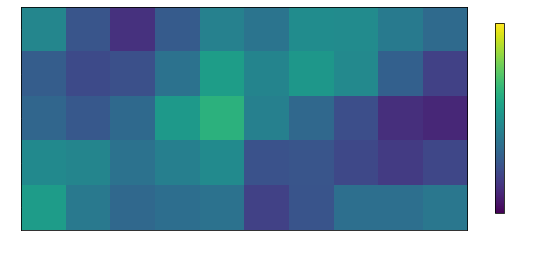

In [32]:
plt.figure(figsize=(10,5))
# ATTENTION: Inverse cuFFT needs scaling!
plt.imshow(grf_gpu.get()/nx/ny, vmin=-2, vmax=2)
plt.colorbar(shrink=0.7)

## Testing

In [33]:
def grf_CPU(cov_toepitz):
    ny, nx = cov_toepitz.shape
    
    u = np.random.normal(size=(ny,nx))

    ctf = np.fft.rfft2(cov_toepitz)
    ctfsm = np.sqrt(np.maximum(0,ctf))
    uf = np.fft.rfft2(u)
    grf = np.fft.irfft2(ctfsm*uf).real

    return grf

In [34]:
def grf_GPU(cov_toepitz):
    gpu_ctx = Common.CUDAContext()
    gpu_stream = cuda.Stream()

    ny, nx = cov_toepitz.shape
    u_gpu = gpuarray.empty((ny,nx), np.float32)

    rng = XORWOWRandomNumberGenerator()
    rng.fill_normal(u_gpu, stream=gpu_stream)

    ct_gpu = gpuarray.to_gpu(cov_toepitz.astype(np.float32))
    ctf_gpu = gpuarray.empty((ny//2+1, nx//2+1), np.complex64)
    plan = Plan((ny,nx), np.float32, np.complex64, stream=gpu_stream)
    fft(ct_gpu, ctf_gpu, plan)

    uf_gpu = gpuarray.empty((ny//2+1,nx//2+1), np.complex64)
    plan = Plan((ny,nx), np.float32, np.complex64, stream=gpu_stream)
    fft(u_gpu, uf_gpu, plan)

    tmp_gpu = gpuarray.to_gpu((np.sqrt(np.maximum(ctf_gpu.get().real,0)) * uf_gpu.get()).astype(np.complex64))

    grf_gpu = gpuarray.empty((ny,nx), np.float32)
    plan_inv = Plan(grf_gpu.shape, np.complex64, np.float32, stream=gpu_stream)
    ifft(tmp_gpu, grf_gpu, plan_inv)

    grf = grf_gpu.get()

    # https://github.com/lebedov/scikit-cuda/issues/308

    return grf

In [35]:
N = 10

In [36]:
mean_cpu = np.zeros_like(cov_toepitz)

for t in range(N):
    mean_cpu += grf_CPU(cov_toepitz)/N

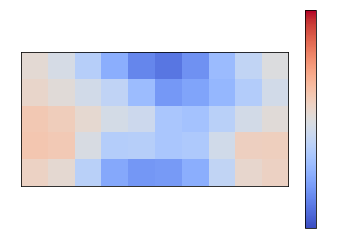

In [49]:
plt.imshow(mean_cpu, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar()

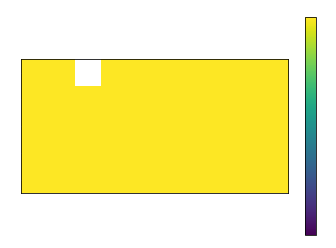

In [39]:
plt.imshow(mean_gpu, vmax=1)
plt.colorbar()

#### FFT via PyCuda Kernels (fails)

In [40]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [41]:
import numpy
a = numpy.random.randn(4,4)
a = a.astype(numpy.float32)

a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)

mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)
#Allocate,generateandtransfer
func = mod.get_function("doublify")
func(a_gpu, block=(4,4,1))

a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled,a_gpu)
print(a, "\n\n", a_doubled)

[[-1.5003844   0.2500524   0.9855176   0.6651797 ]
 [ 1.041063    0.00748707  0.49805215 -2.7207828 ]
 [-0.6500904  -0.6256787   0.14705338  0.29121545]
 [ 1.1848817  -0.57358164 -1.1954104   0.561714  ]] 

 [[-3.000769    0.5001048   1.9710352   1.3303595 ]
 [ 2.082126    0.01497414  0.9961043  -5.4415655 ]
 [-1.3001808  -1.2513574   0.29410675  0.5824309 ]
 [ 2.3697634  -1.1471633  -2.3908207   1.123428  ]]


In [42]:
kernel = gpu_ctx.get_kernel("fft.cu")

In [43]:
func = kernel.get_function("doublify")

In [44]:
func.prepare("f")

In [45]:
func.prepared_async_call((4,4),(1,1,1),gpu_stream, a)

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_413333/348589211.py", line 1, in <module>
    func.prepared_async_call((4,4),(1,1,1),gpu_stream, a)
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/pycuda/driver.py", line 625, in function_prepared_async_call
    arg_buf = pack(func.arg_format, *args)
struct.error: required argument is not a float


error: required argument is not a float